# Exploratory Data Analysis
**Understanding the characteristics of the textual data itself.**   
The goal is to identify patterns, anomalies, and necessary preprocessing steps before training a model.

In [2]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from collections import Counter
from datasets import load_dataset
#from itertools import combinations
from functools import reduce
from spacy.matcher import PhraseMatcher
from rapidfuzz import process, fuzz  # faster fuzzy matching

In [3]:
# Setting display options
pd.set_option('display.max_colwidth', 180)

## Initial Exploration

In [4]:
# Loading dataset
recipes_df = load_dataset("json", data_files="../data/recipe.json")
df = recipes_df["train"].to_pandas()
df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,Air Fryer Potato Slices with Dipping Sauce,Air Fryer Recipes,Air Fryer Recipes,"These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the ...","[3/4 cup ketchup, 1/2 cup beer, 1 tablespoon Worcestershire sauce, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, olive oil cooking spray, 1/2 teaspoon gar...","[Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat,...",9,5
1,Gochujang Pork Belly Bites,Air Fryer Recipes,Air Fryer Recipes,"These gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicious. Whether you finish them with the gochujang sauce in the air fryer, or just d...","[1 pound pork belly, 1/4 cup gochujang, 2 tablespoons soy sauce, 1 tablespoon honey,, 1 teaspoon ground ginger]","[Preheat an air fryer to 400 degrees F (200 degrees C)., Place pork belly pieces in the basket in a single layer, not touching. Air fry for 8 to 9 minutes; turn over and air fr...",5,4
2,3-Ingredient Air Fryer Everything Bagel Chicken Strips,Air Fryer Recipes,Air Fryer Recipes,"These 3-ingredient air fryer everything bagel chicken strips are simple, flavorful, and delicious. Chicken tenders are easy to cook, but this easy? Wow! 5 minutes of prep time,...","[1 ¼ pounds chicken tenders, 1 tablespoon olive oil, 1/3 cup everything bagel seasoning or to taste]","[Gather all ingredients. Preheat an air fryer to 400 degrees F (200 degrees C), or according to manufacturer's instructions., Place tenders in a bowl. Add oil and toss to coat....",3,4
3,Air Fryer Everything Bagel Chicken Cutlets,Air Fryer Recipes,Air Fryer Recipes,"These air fryer everything bagel chicken cutlets, breaded with everything-seasoned panko breadcrumbs and air fried, are drizzled with a spicy-sweet ginger garlic sauce.","[4 chicken cutlets (about 1 pound total), salt and freshly ground black pepper to taste, 3/4 cup all-purpose flour, 2 large eggs, 2 tablespoons milk, 3 ablespoons verything Bag...","[Preheat an air fryer to 400 degrees F (200 degrees C), or according to manufacturer's instructions., Pat chicken cutlets dry with paper towels; season lightly with salt and pe...",9,9
4,Air Fryer Honey Sriracha Salmon Bites,Air Fryer Recipes,Air Fryer Recipes,"These air fryer honey Sriracha salmon bites are cubes of salmon, lightly seasoned with salt, pepper, olive oil, and a touch of Sriracha, then air fried to crispy perfection and...","[1 tablespoon soy sauce, 1 tablespoon honey, 1 tablespoon Sriracha, 1 teaspoon rice vinegar, 1/4 teaspoon granulated garlic]","[Preheat an air fryer to 400 degrees F (200 degrees C)., Whisk soy sauce, honey, 1 tablespoon Sriracha, rice vinegar, and granulated garlic together in a small bowl. Set aside....",5,5


In [5]:
# Viewing content of first record
recipes_df["train"][0]

{'recipe_title': 'Air Fryer Potato Slices with Dipping Sauce',
 'category': 'Air Fryer Recipes',
 'subcategory': 'Air Fryer Recipes',
 'description': "These air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a French fry and a potato chip. Do take the time to make the dipping sauce—it's worth it.",
 'ingredients': ['3/4 cup ketchup',
  '1/2 cup beer',
  '1 tablespoon Worcestershire sauce',
  '1/2 teaspoon onion powder',
  '1/4 teaspoon cayenne',
  '2 baking potatoes',
  'olive oil cooking spray',
  '1/2 teaspoon garlic powder',
  'salt and freshly ground black pepper'],
 'directions': ['Combine ketchup, beer, Worcestershire sauce, onion powder, and cayenne in a small saucepan. Bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. Remove from heat, and cool. Cover and store in the refrigerator until ready to use.',
  'Preheat the air fryer to 400 degrees F (200 degrees C). Spray the basket with cooking spray or line w

In [6]:
# Number of rows and columns
df.shape

(62126, 8)

In [7]:
# Concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62126 entries, 0 to 62125
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     62126 non-null  object
 1   category         62126 non-null  object
 2   subcategory      62126 non-null  object
 3   description      62126 non-null  object
 4   ingredients      62126 non-null  object
 5   directions       62126 non-null  object
 6   num_ingredients  62126 non-null  int64 
 7   num_steps        62126 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 3.8+ MB


In [8]:
# Missing values
df.isna().sum()

recipe_title       0
category           0
subcategory        0
description        0
ingredients        0
directions         0
num_ingredients    0
num_steps          0
dtype: int64

In [9]:
# Descriptive statistics
df.describe()

,num_ingredients,num_steps
count,62126.000000,62126.000000
mean,9.017448,4.661865
std,3.830323,2.310253
min,1.000000,1.000000
25%,6.000000,3.000000
50%,9.000000,4.000000
75%,11.000000,6.000000
max,35.000000,25.000000


## Dealing with Duplicates

In [10]:
# Duplicates
duplicates_df = df[df.duplicated(keep=False, subset=["recipe_title", "description"])]
print(f"Initial duplicate check:\n{len(duplicates_df)} found!")

Initial duplicate check:
51460 found!


In [11]:
# Inspecting records with their matching duplicates
duplicates_df.sort_values(by=["recipe_title", "description"])[0:9]

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
15989,"""Black Magic"" Chocolate Chip Cookies",Chocolate Chip Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cookies use activated charcoal powder to create a devilishly dark dough. The cookies, however dark and mysterious, taste just like our ...","[1 cup unsalted butter, soft, 1 cup white sugar, 1/2 cup light brown sugar, 1 large egg, 1 tablespoon activated charcoal powder, 1 1/4 teaspoons vanilla extract, 2 tablespoons ...","[Beat butter, white sugar, and brown sugar together with an electric mixer until creamy. and sugars together. Add egg, charcoal, vanilla, milk, salt, and baking soda, and beat ...",11,5
17650,"""Black Magic"" Chocolate Chip Cookies",Christmas Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cookies use activated charcoal powder to create a devilishly dark dough. The cookies, however dark and mysterious, taste just like our ...","[1 cup unsalted butter, soft, 1 cup white sugar, 1/2 cup light brown sugar, 1 large egg, 1 tablespoon activated charcoal powder, 1 1/4 teaspoons vanilla extract, 2 tablespoons ...","[Beat butter, white sugar, and brown sugar together with an electric mixer until creamy. and sugars together. Add egg, charcoal, vanilla, milk, salt, and baking soda, and beat ...",11,5
21250,"""Black Magic"" Chocolate Chip Cookies",Cookies,Chocolate Chip Cookies,"Chef John's ""black magic"" chocolate chip cookies use activated charcoal powder to create a devilishly dark dough. The cookies, however dark and mysterious, taste just like our ...","[1 cup unsalted butter, soft, 1 cup white sugar, 1/2 cup light brown sugar, 1 large egg, 1 tablespoon activated charcoal powder, 1 1/4 teaspoons vanilla extract, 2 tablespoons ...","[Beat butter, white sugar, and brown sugar together with an electric mixer until creamy. and sugars together. Add egg, charcoal, vanilla, milk, salt, and baking soda, and beat ...",11,5
34013,"""Black Magic"" Chocolate Chip Cookies",Halloween,Halloween Cookies,"Chef John's ""black magic"" chocolate chip cookies use activated charcoal powder to create a devilishly dark dough. The cookies, however dark and mysterious, taste just like our ...","[1 cup unsalted butter, soft, 1 cup white sugar, 1/2 cup light brown sugar, 1 large egg, 1 tablespoon activated charcoal powder, 1 1/4 teaspoons vanilla extract, 2 tablespoons ...","[Beat butter, white sugar, and brown sugar together with an electric mixer until creamy. and sugars together. Add egg, charcoal, vanilla, milk, salt, and baking soda, and beat ...",11,5
30851,"""CranCrack"" Cranberry Salad",Fruit Salads,Fruit Salads,"This was my mothers recipe, and named by my son because it is so addictive. By replacing the Jell-O® with sugar-free Jello-O®, using no-sugar-added pineapple, and your choice o...","[1 (12 ounce) package fresh cranberries, 1 large orange, peeled, 2 cups boiling water, 1 cup white sugar, 1 (6 ounce) package cherry-flavored gelatin mix (such as Jell-O®), 1 (...","[Process cranberries and orange in a food processor until finely ground., Stir boiling water, sugar, and gelatin together in a bowl until gelatin and sugar dissolve. Add cranbe...",6,2
38999,"""CranCrack"" Cranberry Salad",Jell-O Salads,Jell-O Salads,"This was my mothers recipe, and named by my son because it is so addictive. By replacing the Jell-O® with sugar-free Jello-O®, using no-sugar-added pineapple, and your choice o...","[1 (12 ounce) package fresh cranberries, 1 large orange, peeled, 2 cups boiling water, 1 cup white sugar, 1 (6 ounce) package cherry-flavored gelatin mix (such as Jell-O®), 1 (...","[Process cranberries and orange in a food processor until finely ground., Stir boiling water, sugar, and gelatin together in a bowl until gelatin and sugar dissolve. Add cranbe...",6,2
16570,"""Egg Not"" (Eggless Eggnog)",Christmas,Christmas Drink Recipes,I developed this recipe because of my love for eggnog and

For each set of duplicates, we identified that the content is identical but has different categories and subcategories. This is because they've been classified across:
- Seasonal categories (Christmas, Halloween)
- Use-case categories (Cookies, Fruit salads)
- High-level categories (Desserts, Snacks)
- Ingredient-based categories (Eggnog category)

For a recipe recommendation system based on available ingredients,
- They do create redundancy and may bias similarity/recommendation scores.
- They also inflate the dataset artificially.
- Removing or consolidating them improves search, embeddings, clustering, and recall quality.

**We need a clean, unique recipe dataset.**

In [12]:
# Detecting duplicates across lists and strings, ignoring order and case
def normalize_column(col):
    """
    Normalize a column for duplicate detection:
    - Strings → lowercase, stripped
    - Lists/arrays → lowercase, stripped, sorted, converted to tuple
    """
    if isinstance(col, str):
        return col.strip().lower()
    elif isinstance(col, (list, np.ndarray)):
        # Lowercase each element, strip spaces, sort, convert to tuple
        cleaned = tuple(sorted([str(x).strip().lower() for x in col]))
        return cleaned
    return col

# Columns to check for duplicates
cols_to_check = ["recipe_title", "description", "ingredients", "directions"]

# Create normalized columns
normalized_cols = {col: df[col].apply(normalize_column) for col in cols_to_check}

# Combine into a DataFrame
norm_df = df.assign(**normalized_cols)

# Find duplicates
duplicates_norm_df = norm_df[norm_df.duplicated(subset=cols_to_check, keep=False)]

print(f"Number of duplicates: {len(duplicates_norm_df)} found!")

Number of duplicates: 51458 found!


***Before normalization***
- Checked duplicates only on `["recipe_title", "description"]`.
- Result: 51,460 duplicates. This means that many recipes have identical titles and descriptions, ignoring ingredients and directions.
- Ingredients and directions weren't considered, so two recipes with the same title/description but different ingredients/directions would still count as duplicates.

***After normalization***
- Checked duplicates on `["recipe_title", "description", "ingredients", "directions"]`.
- Result: 51,458 duplicates.
- Why fewer? Only 2 recipes that had identical title+description actually differ in ingredients or directions.
- Normalization ensures lists are sorted and strings are lowercased and stripped
- So now duplicates are more strict and precise, not just title/description.

***What this tells us***
- Most duplicates were indeed exact duplicates in title/description, regardless of ingredients/directions.
- Only 2 cases have the same title/description but different ingredients/directions.


*IMPORTANT NOTE: The `keep` parameter in duplicated() was set to `False`, so all duplicates were counted. During cleaning, for every duplicate pair, one entry is retained while the remaining ones are flagged as duplicates (keep='first').*  
*With this principle in place, the total number of duplicates to be excluded is **37,102***.

In [13]:
# Some aspects of the exploration will require using data that has no duplicates
deduplicated_df = norm_df.drop_duplicates(subset=["recipe_title", "description", "ingredients", "directions"])
deduplicated_df = deduplicated_df.copy()

In [13]:
# Concise summary of dataset
deduplicated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25024 entries, 0 to 62032
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   recipe_title     25024 non-null  object
 1   category         25024 non-null  object
 2   subcategory      25024 non-null  object
 3   description      25024 non-null  object
 4   ingredients      25024 non-null  object
 5   directions       25024 non-null  object
 6   num_ingredients  25024 non-null  int64 
 7   num_steps        25024 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.7+ MB


In [14]:
# Descriptive statistics
deduplicated_df.describe(include='all')

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
count,25024,25024,25024,25024,25024,25024,25024.000000,25024.000000
unique,24971,219,959,25015,24967,25013,NaN,NaN
top,mediterranean flatbread,Appetizers And Snacks,Apple Pie,"ziti is layered with sausage, ricotta, mozzarella and tomato sauce, then baked until bubbling.","(cooking spray,)",(pour beans into a multi-functional pressure cooker (such as instant pot). cover with a few inches of cool water. close and lock the lid. select manual; set timer for 28 minute...,NaN,NaN
freq,2,1594,64,2,29,2,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,9.026455,4.321172
std,NaN,NaN,NaN,NaN,NaN,NaN,3.811175,2.174883
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,4.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,5.000000


## Category & Subcategory Analysis

In [15]:
# Number of categories
print(f"Number of categories in raw dataset: {df["category"].str.lower().nunique()}")

# Number of categories after removing duplicates
print(f"Number of categories in deduplicated dataset: {deduplicated_df["category"].str.lower().nunique()}")

Number of categories in raw dataset: 267
Number of categories in deduplicated dataset: 219


In [16]:
# Highest and lowest count per category
cat_counts1 = df["category"].value_counts()
cat_counts2 = deduplicated_df["category"].value_counts()

# df
top_category1 = cat_counts1.idxmax()
top_c_count1 = cat_counts1.max()
bottom_category1 = cat_counts1.idxmin()
bottom_c_count1 = cat_counts1.min()

# deduplicated_df
top_category2 = cat_counts2.idxmax()
top_c_count2 = cat_counts2.max()
bottom_category2 = cat_counts2.idxmin()
bottom_c_count2 = cat_counts2.min()

print("Raw dataset:")
print(f"Top Category: {top_category1} ({top_c_count1})")
print(f"Bottom Category: {bottom_category1} ({bottom_c_count1})")
print("\nDeduplicated dataset:")
print(f"Top Category: {top_category2} ({top_c_count2})")
print(f"Bottom Category: {bottom_category2} ({bottom_c_count2})")

Raw dataset:
Top Category: Main Dishes (3387)
Bottom Category: Waldorf Salads (2)

Deduplicated dataset:
Top Category: Appetizers And Snacks (1594)
Bottom Category: Divinity (1)


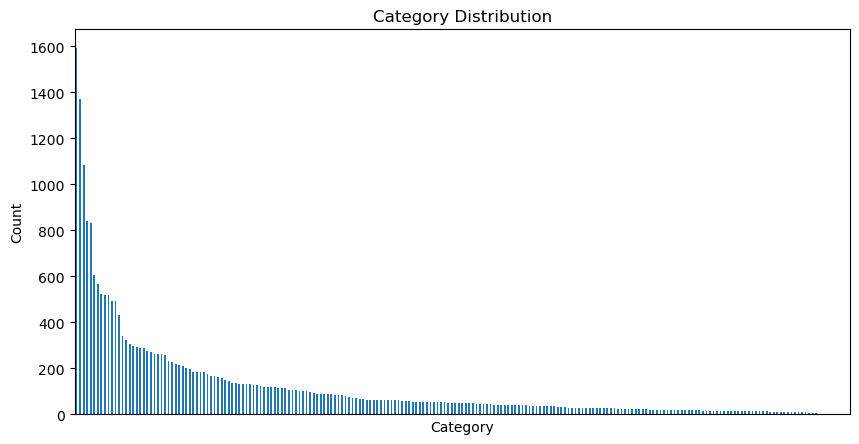

In [17]:
# Category distribution
plt.figure(figsize=(10,5))
deduplicated_df['category'].value_counts().plot(kind='bar')
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(ticks=[])
plt.show()

In [18]:
# Number of subcategories
print(f"Number of subcategories in raw dataset: {df["subcategory"].str.lower().nunique()}")

# Number of subcategories after removing duplicates
print(f"Number of subcategories in deduplicated dataset: {deduplicated_df["subcategory"].str.lower().nunique()}")

Number of subcategories in raw dataset: 1032
Number of subcategories in deduplicated dataset: 959


In [19]:
# Highest and lowest count per subcategory
subcat_counts1 = df["subcategory"].value_counts()
subcat_counts2 = deduplicated_df["subcategory"].value_counts()

# df
top_subcategory1 = subcat_counts1.idxmax()
top_sc_count1 = subcat_counts1.max()
bottom_subcategory1 = subcat_counts1.idxmin()
bottom_sc_count1 = subcat_counts1.min()

# deduplicated_df
top_subcategory2 = subcat_counts2.idxmax()
top_sc_count2 = subcat_counts2.max()
bottom_subcategory2 = subcat_counts2.idxmin()
bottom_sc_count2 = subcat_counts2.min()

print("Raw dataset:")
print(f"Top Category: {top_category1} ({top_sc_count1})")
print(f"Bottom Category: {bottom_category1} ({bottom_sc_count1})")
print("\nDeduplicated dataset:")
print(f"Top Category: {top_category2} ({top_sc_count2})")
print(f"Bottom Category: {bottom_category2} ({bottom_sc_count2})")

Raw dataset:
Top Category: Main Dishes (320)
Bottom Category: Waldorf Salads (1)

Deduplicated dataset:
Top Category: Appetizers And Snacks (64)
Bottom Category: Divinity (1)


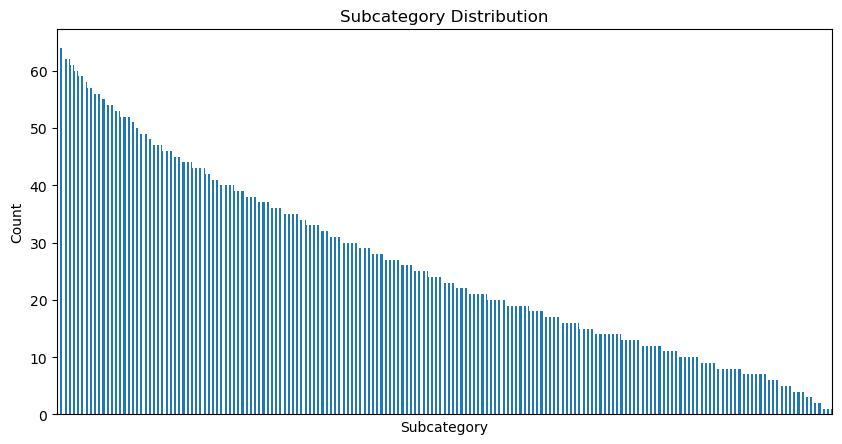

In [20]:
# Sub-category distribution
plt.figure(figsize=(10,5))
deduplicated_df['subcategory'].value_counts().plot(kind='bar')
plt.title("Subcategory Distribution")
plt.xlabel("Subcategory")
plt.ylabel("Count")
plt.xticks(ticks=[])
plt.show()

## Token Count in Recipe Title and Description

In [21]:
# Defining function to get length of tokens for recipe_title and description fields
nlp_tok = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])
# Some pipeline components were disbaled because we’re only counting tokens and checking if a token is punctuation, whitespace, or a stopword.
spacy_stopwords = nlp_tok.Defaults.stop_words

def spacy_cleaned_word_count(text):
    if not isinstance(text, str):
        return 0
    
    # Lowercasing helps spaCy handle tokens consistently
    doc = nlp_tok(text.lower())
    
    # Count tokens that are:
    # - not punctuation
    # - not whitespace
    # - not stopwords
    return sum(
        1 for token in doc
        if not token.is_punct
        and not token.is_space
        and token.text not in spacy_stopwords
    )

In [22]:
# Creating new fields containing the number of tokens
deduplicated_df["recipe_title_len"] = deduplicated_df["recipe_title"].apply(spacy_cleaned_word_count)
deduplicated_df["description_len"] = deduplicated_df["description"].apply(spacy_cleaned_word_count)

In [14]:
deduplicated_df.head()

,recipe_title,category,subcategory,description,ingredients,directions,num_ingredients,num_steps
0,air fryer potato slices with dipping sauce,Air Fryer Recipes,Air Fryer Recipes,"these air fryer potato slices, served with a beer ketchup dipping sauce, are a tasty finger food somewhere between a french fry and a potato chip. do take the time to make the ...","(1 tablespoon worcestershire sauce, 1/2 cup beer, 1/2 teaspoon garlic powder, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, 3/4 cup ketchup, olive oil coo...","(combine ketchup, beer, worcestershire sauce, onion powder, and cayenne in a small saucepan. bring to a boil, then reduce heat, and simmer for 3 to 5 minutes. remove from heat,...",9,5
1,gochujang pork belly bites,Air Fryer Recipes,Air Fryer Recipes,"these gochujang pork belly bites are sweet and spicy, crispy and crunchy, and absolutely delicious. whether you finish them with the gochujang sauce in the air fryer, or just d...","(1 pound pork belly, 1 tablespoon honey,, 1 teaspoon ground ginger, 1/4 cup gochujang, 2 tablespoons soy sauce)","(meanwhile, for sauce, stir gochujang, soy sauce, hot honey, and ginger together in a medium bowl., place pork belly pieces in the basket in a single layer, not touching. air f...",5,4
2,3-ingredient air fryer everything bagel chicken strips,Air Fryer Recipes,Air Fryer Recipes,"these 3-ingredient air fryer everything bagel chicken strips are simple, flavorful, and delicious. chicken tenders are easy to cook, but this easy? wow! 5 minutes of prep time,...","(1 tablespoon olive oil, 1 ¼ pounds chicken tenders, 1/3 cup everything bagel seasoning or to taste)","(gather all ingredients. preheat an air fryer to 400 degrees f (200 degrees c), or according to manufacturer's instructions., place tenders in a bowl. add oil and toss to coat....",3,4
3,air fryer everything bagel chicken cutlets,Air Fryer Recipes,Air Fryer Recipes,"these air fryer everything bagel chicken cutlets, breaded with everything-seasoned panko breadcrumbs and air fried, are drizzled with a spicy-sweet ginger garlic sauce.","(1 1/2 cups panko breadcrumbs, 2 large eggs, 2 tablespoons milk, 3 ablespoons verything bagel seasoning, 3/4 cup all-purpose flour, 4 chicken cutlets (about 1 pound total), oli...","(add cutlets to the bag with flour. seal the bag and toss until cutlets are coated., air fry for 8 to 12 minutes, turning over halfway through, if desired. thin cutlets will ta...",9,9
4,air fryer honey sriracha salmon bites,Air Fryer Recipes,Air Fryer Recipes,"these air fryer honey sriracha salmon bites are cubes of salmon, lightly seasoned with salt, pepper, olive oil, and a touch of sriracha, then air fried to crispy perfection and...","(1 tablespoon honey, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon rice vinegar, 1/4 teaspoon granulated garlic)","(cook in the preheated air fryer for 4 minutes. gently turn salmon pieces and cook until salmon flakes easily with a fork, 3 to 4 more minutes. place on a serving platter, driz...",5,5


In [27]:
# Maximum and minimum lenghts for recipe title
print(f"Maximum length for recipe title tokens {deduplicated_df["recipe_title_len"].max()}")
print(f"Minimum length for recipe title tokens {deduplicated_df["recipe_title_len"].min()}")

Maximum length for recipe title tokens 13
Minimum length for recipe title tokens 1


In [28]:
# Maximum and minimum lenghts for description
print(f"Maximum length for description tokens {deduplicated_df["description_len"].max()}")
print(f"Minimum length for description tokens {deduplicated_df["description_len"].min()}")

Maximum length for description tokens 72
Minimum length for description tokens 1


***Visualizing token length distributions***

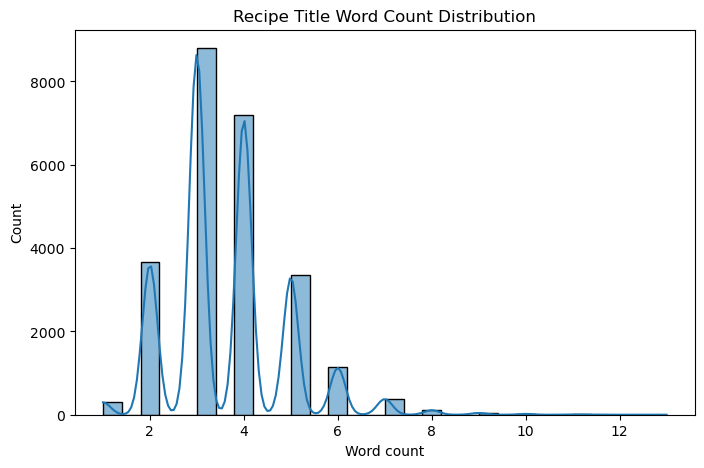

In [29]:
# Recipe Title Length
plt.figure(figsize=(8,5))
sns.histplot(deduplicated_df["recipe_title_len"], bins=30, kde=True)
plt.title("Recipe Title Word Count Distribution")
plt.xlabel("Word count")
plt.show()

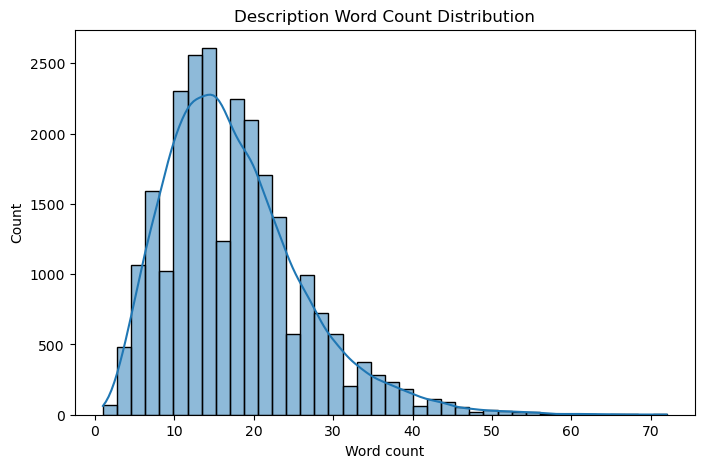

In [30]:
# Description length
plt.figure(figsize=(8,5))
sns.histplot(deduplicated_df["description_len"], bins=40, kde=True)
plt.title("Description Word Count Distribution")
plt.xlabel("Word count")
plt.show()

## 🥕 INGREDIENT-CENTRIC ANALYSIS

### First Phase of Cleaning Ingredients
Aimed at extracting only the core ingredient names

In [14]:
# Extracting only the ingredients field
ingredients_df = deduplicated_df[["ingredients"]]
ingredients_df = ingredients_df.copy()
ingredients_df.shape

(25024, 1)

In [ ]:
def clean_ingredients_v1(ing):
    ing = ing.lower().strip()
    
    # 1. Remove quantities (fractions, decimals, integers)
    ing = re.sub(r'(\d+/\d+|\d+(\.\d+)?)', '', ing)
    
    # 2. Remove units
    units = ['cup', 'cups', 'tablespoon', 'tablespoons', 'tsp', 'teaspoon', 'teaspoons',
             'oz', 'ounce', 'ounces', 'lb', 'pound', 'pounds', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'small', 'large']
    pattern = r'\b(?:' + '|'.join(units) + r')\b'
    ing = re.sub(pattern, '', ing)
    
    # 3. Remove extra words often used for preparation
    prep_words = ['fresh', 'freshly', 'ground', 'minced', 'chopped', 'diced', 'sliced', 
                  'baking', 'cooking', 'spray', 'for garnish', 'to taste']
    pattern2 = r'\b(?:' + '|'.join(prep_words) + r')\b'
    ing = re.sub(pattern2, '', ing)
    
    # 4. Remove punctuation
    ing = re.sub(r'[^\w\s]', '', ing)
    
    # 5. Split compound ingredients like 'salt and pepper'
    parts = re.split(r'\band\b|\&', ing)
    parts = [p.strip() for p in parts if p.strip()]
    
    # 6. Lemmatize using SpaCy
    cleaned_parts = []
    for p in parts:
        doc = nlp(p) # nlp = spacy.load("en_core_web_md")
        lemmas = [tok.lemma_ for tok in doc if tok.is_alpha]
        if lemmas:
            cleaned_parts.append(' '.join(lemmas))
    
    return cleaned_parts

In [ ]:
# Apply to dataset
ingredients_df['clean_ingredients_v1'] = ingredients_df['ingredients'].apply(lambda lst: [i for ing in lst for i in clean_ingredients_v1(ing)])

# Preview
ingredients_df[['ingredients', 'clean_ingredients_v1']].head(10)

,ingredients,clean_ingredients_v1
0,"(1 tablespoon worcestershire sauce, 1/2 cup beer, 1/2 teaspoon garlic powder, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, 3/4 cup ketchup, olive oil coo...","[worcestershire sauce, beer, garlic powder, onion powder, cayenne, potato, ketchup, olive oil, salt, black pepper]"
1,"(1 pound pork belly, 1 tablespoon honey,, 1 teaspoon ground ginger, 1/4 cup gochujang, 2 tablespoons soy sauce)","[pork belly, honey, ginger, gochujang, soy sauce]"
2,"(1 tablespoon olive oil, 1 ¼ pounds chicken tenders, 1/3 cup everything bagel seasoning or to taste)","[olive oil, chicken tender, everything bagel seasoning or]"
3,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2 tablespoons milk, 3 ablespoons verything bagel seasoning, 3/4 cup all-purpose flour, 4 chicken cutlets (about 1 pound total), oli...","[panko breadcrumb, egg, milk, ablespoon verythe bagel seasoning, allpurpose flour, chicken cutlet about total, olive oil, parchment, salt, black pepper]"
4,"(1 tablespoon honey, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon rice vinegar, 1/4 teaspoon granulated garlic)","[honey, soy sauce, sriracha, rice vinegar, granulate garlic]"
5,"(1 teaspoon lime juice, 2 ears corn, shucked and halved, 2 teaspoons crumbled cotija cheese, 4 sprigs fresh cilantro, or to taste (optional), ¼ cup mayonnaise, ¼ teaspoon chili...","[lime juice, ear corn shuck, halve, crumble cotija cheese, sprig cilantro or optional, mayonnaise, chili powder]"
6,"(1 lime, zested and juiced, 1 tablespoon fresh ginger, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon granulated garlic, 1/3 cup creamy peanut butter, 2 cups cooked ...","[lime zest, juice, ginger, soy sauce, sriracha, granulate garlic, creamy peanut butter, cook rice or as need, thai sweet chili sauce, skinless boneless chicken thigh, cilantro,..."
7,"(1 onion, 1/2 teaspoon cayenne pepper, 1/4 cup all-purpose flour, 1/4 teaspoon salt, or to taste, cooking spray)","[onion, cayenne pepper, allpurpose flour, salt or]"
8,"(1 pound baby carrots, 2 tablespoons butter,, 3 tablespoons hot honey, such as mike's hot honey®, nonstick cooking spray)","[baby carrot, butter, hot honey such as mike hot honey, nonstick]"
9,"(1 1/2 teaspoons olive oil, 1 large onion, salt and freshly ground black pepper)","[olive oil, onion, salt, black pepper]"


In [ ]:
#  More detailed preview
ingredients_df['clean_ingredients_v1'][0:50]

0                                                                      [worcestershire sauce, beer, garlic powder, onion powder, cayenne, potato, ketchup, olive oil, salt, black pepper]
1                                                                                                                                       [pork belly, honey, ginger, gochujang, soy sauce]
2                                                                                                                              [olive oil, chicken tender, everything bagel seasoning or]
3                                [panko breadcrumb, egg, milk, ablespoon verythe bagel seasoning, allpurpose flour, chicken cutlet about total, olive oil, parchment, salt, black pepper]
4                                                                                                                            [honey, soy sauce, sriracha, rice vinegar, granulate garlic]
5                                                                     

***Ingredient frequency*** (using output of clean_ingredients_v1)

In [ ]:
# List of all ingredients
v1_clean_ingredients = [ing for lst in ingredients_df["clean_ingredients_v1"] for ing in lst]

ingredient_frequency_v1 = Counter(v1_clean_ingredients)

freq_df = pd.DataFrame(
    ingredient_frequency_v1.items(), 
    columns=["ingredient", "count"]
).sort_values("count", ascending=False)

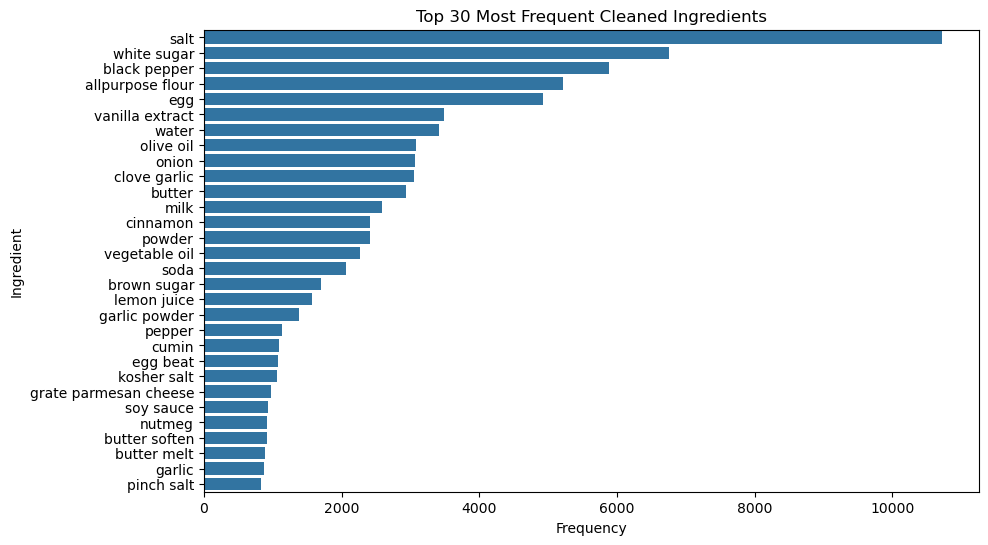

In [36]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df.head(30),
    x="count", y="ingredient"
)
plt.title(f"Top 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

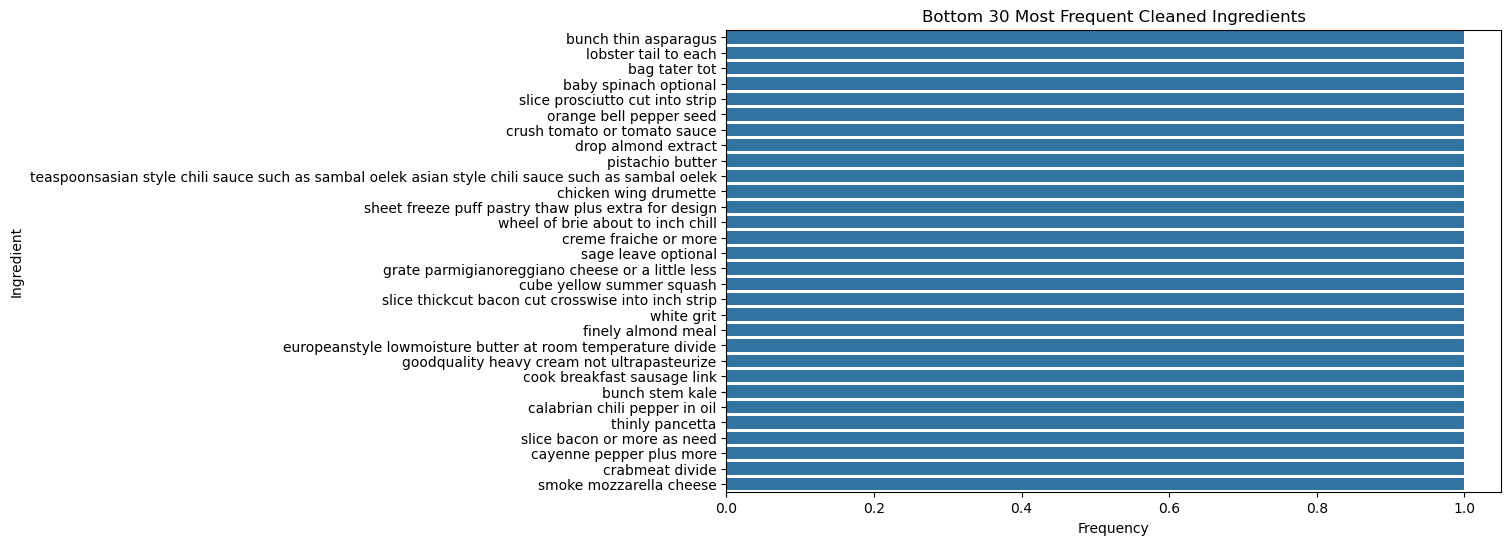

In [37]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df.tail(30),
    x="count", y="ingredient"
)
plt.title(f"Bottom 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

In [38]:
# Number of ingredients that appear once
print(f"{freq_df[freq_df["count"] == freq_df["count"].min()].shape[0]} ingredients appear only once")

19026 ingredients appear only once


#### Observation
There seem to be some descriptive terms in the ingredient field (e.g., 'finely shred mozzarella cheese', 'mashed purple sweet potato').

✔ Problem 1 — Units & quantities removed imperfectly  
Words like “tablespoon”, “teaspoon”, “very”, “the” combine after removal → “ablespoon verythe”

✔ Problem 2 — We didn't remove brand-specific descriptors  
Examples: “such as tyson”, “such as rotel”, “such as pillsbury”, “such as goya”, “johnsonville”

✔ Problem 3 — We didn’t remove preparation instructions  
Examples: “cut into wedges”,“pat dry”, “for garnish”, “if desired”, "divide", "thaw if frozen"

✔ Problem 4 — Compound ingredients remain un-split  
“assorted root vegetable carrot parsnip beet onion” , “salt pepper”

✔ Problem 5 — Fresh, whole, baby, medium, optional descriptors remain  
Words like: baby, medium, mini, whole, fresh, optional

### Stronger Ingredient Cleaning Version

In [ ]:
# Common words to remove
REMOVE_WORDS = set(
    """
    baby medium mini small large fresh freshly ground optional divided cooked raw prepared cut sliced chopped diced minced halved quartered grated trimmed 
    pat dry thaw drained seeded peeled whole boneless skinless skin-on bone-in giblet remove plus more into for garnish extra additional taste seed seedless package bag 
    box can jar bottle container about inch inches refrigerate crush crushed
    """.split())

# Common units
UNITS = set(
    """
    cup cups tablespoon tablespoons tbsp teaspoon teaspoons tsp oz ounce ounces lb pound pounds gram grams kg kilogram kilograms 
    pinch pint quart stick slice slices clove cloves dash sprig
    """.split())

# Brand names
BRANDS = set(
    """
    tyson goya pillsbury rotel johnsonville cheezit el pato patak ortega trader joe
    """.split())

# Common ingredient synonyms
SYNONYMS = {
    "allpurpose flour": "flour",
    "plain flour": "flour",
    "extra virgin olive oil": "olive oil",
    "caster sugar": "sugar"
}

# Unicode fractions
UNICODE_FRAC = {
    "½": "1/2", "¼": "1/4", "¾": "3/4", "⅓": "1/3", "⅔": "2/3", "⅛": "1/8"
}

# Multi-word ingredient phrases
PHRASES = ["olive oil", "all-purpose flour", "baking soda", "baking powder", "brown sugar"]
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(p) for p in PHRASES]
matcher.add("INGREDIENTS", patterns)

# Common spelling corrections
SPELL_CORRECTIONS = {
    "ablespoons": "tablespoons",
    "verything": "everything",
    "suger": "sugar",
    "tomatto": "tomato",
}

# Function to correct spelling using fuzzy matching
def correct_spelling(word, valid_words, threshold=80):
    # extractOne now returns either None or a dict-like object
    result = process.extractOne(word, valid_words, scorer=fuzz.ratio)
    
    if result is None:
        return word  # no match found
    
    # result can be (match, score, index) in newer versions
    if isinstance(result, tuple):
        match, score = result[:2]  # only take first two elements
    else:
        # fallback
        return word
    
    if score >= threshold:
        return match
    return word

# Full ingredient cleaning function
def clean_ingredients_v2(raw):
    if not isinstance(raw, str):
        return []

    # Lowercase
    raw = raw.lower().strip()

    # Replace unicode fractions
    for frac, val in UNICODE_FRAC.items():
        raw = raw.replace(frac, val)

    # Replace common spelling mistakes
    for wrong, correct in SPELL_CORRECTIONS.items():
        raw = re.sub(rf"\b{wrong}\b", correct, raw)

    # Remove numbers (except letters attached like B12)
    raw = re.sub(r'\b\d+(\.\d+)?\b(?![a-zA-Z])', ' ', raw)

    # Remove units
    for u in UNITS:
        raw = re.sub(rf"\b{u}\b", " ", raw)

    # Remove punctuation except connectors
    raw = re.sub(r"[^\w\s/,&-]", " ", raw)

    # Split on connectors
    tokens = re.split(r'\band\b|\bor\b|/|,|&', raw)

    cleaned_items = []

    for token in tokens:
        token = token.strip()
        if not token:
            continue

        words = token.split()
        # Remove stopwords, brands, and filler words
        words = [w for w in words if w.isalpha() and w not in REMOVE_WORDS and w not in BRANDS]

        if not words:
            continue

        # Lemmatize
        doc = nlp(" ".join(words)) # nlp = spacy.load("en_core_web_md")
        lemma_words = [t.lemma_ for t in doc]

        candidate = " ".join(lemma_words)

        # Phrase matching
        doc2 = nlp(candidate)
        matches = matcher(doc2)
        for _, start, end in matches:
            candidate = doc2[start:end].text

        # Synonym replacement
        candidate = SYNONYMS.get(candidate, candidate)

        # Fuzzy spell correction on remaining words
        final_words = []
        for w in candidate.split():
            corrected = correct_spelling(w, list(SYNONYMS.values()) + list(PHRASES))
            final_words.append(corrected)
        final_candidate = " ".join(final_words)

        if final_candidate:
            cleaned_items.append(final_candidate)

    return cleaned_items

In [ ]:
# Apply to dataset
ingredients_df["clean_ingredients_v2"] = ingredients_df["ingredients"].apply(
    lambda lst: [i for raw in lst for i in clean_ingredients_v2(raw)]
)

# Preview
ingredients_df[['ingredients', 'clean_ingredients_v2']].head(10)

,ingredients,clean_ingredients_final
0,"(1 tablespoon worcestershire sauce, 1/2 cup beer, 1/2 teaspoon garlic powder, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, 3/4 cup ketchup, olive oil coo...","[worcestershire sauce, beer, garlic powder, onion powder, cayenne, baking potato, ketchup, olive oil, salt, black pepper]"
1,"(1 pound pork belly, 1 tablespoon honey,, 1 teaspoon ground ginger, 1/4 cup gochujang, 2 tablespoons soy sauce)","[pork belly, honey, ginger, gochujang, soy sauce]"
2,"(1 tablespoon olive oil, 1 ¼ pounds chicken tenders, 1/3 cup everything bagel seasoning or to taste)","[olive oil, chicken tender, everything bagel seasoning, to]"
3,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2 tablespoons milk, 3 ablespoons verything bagel seasoning, 3/4 cup all-purpose flour, 4 chicken cutlets (about 1 pound total), oli...","[panko breadcrumb, egg, milk, everything bagel seasoning, flour, chicken cutlet total, olive oil, parchment, salt, black pepper to]"
4,"(1 tablespoon honey, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon rice vinegar, 1/4 teaspoon granulated garlic)","[honey, soy sauce, sriracha, rice vinegar, granulate garlic]"
5,"(1 teaspoon lime juice, 2 ears corn, shucked and halved, 2 teaspoons crumbled cotija cheese, 4 sprigs fresh cilantro, or to taste (optional), ¼ cup mayonnaise, ¼ teaspoon chili...","[lime juice, ear corn, shuck, crumble cotija cheese, sprig cilantro, to, mayonnaise, chili powder]"
6,"(1 lime, zested and juiced, 1 tablespoon fresh ginger, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon granulated garlic, 1/3 cup creamy peanut butter, 2 cups cooked ...","[lime, zest, juice, ginger, soy sauce, sriracha, granulate garlic, creamy peanut butter, rice, as need, thai sweet chili sauce, chicken thigh, cilantro, cooking spray, peanut, ..."
7,"(1 onion, 1/2 teaspoon cayenne pepper, 1/4 cup all-purpose flour, 1/4 teaspoon salt, or to taste, cooking spray)","[onion, cayenne pepper, flour, salt, to, cooking spray]"
8,"(1 pound baby carrots, 2 tablespoons butter,, 3 tablespoons hot honey, such as mike's hot honey®, nonstick cooking spray)","[carrot, butter, hot honey, such as mike s hot honey, nonstick cooking spray]"
9,"(1 1/2 teaspoons olive oil, 1 large onion, salt and freshly ground black pepper)","[olive oil, onion, salt, black pepper]"


In [ ]:
#  More detailed preview
ingredients_df['clean_ingredients_v2'][0:50]

0                                                               [worcestershire sauce, beer, garlic powder, onion powder, cayenne, baking potato, ketchup, olive oil, salt, black pepper]
1                                                                                                                                       [pork belly, honey, ginger, gochujang, soy sauce]
2                                                                                                                             [olive oil, chicken tender, everything bagel seasoning, to]
3                                                     [panko breadcrumb, egg, milk, everything bagel seasoning, flour, chicken cutlet total, olive oil, parchment, salt, black pepper to]
4                                                                                                                            [honey, soy sauce, sriracha, rice vinegar, granulate garlic]
5                                                                     

In [ ]:
# Comparing results of the two cleaning methods
ingredients_df[ingredients_df['clean_ingredients_v1'] != ingredients_df['clean_ingredients_v2']][["clean_ingredients_v1", "clean_ingredients_v2"]]

,clean_ingredients_v1,clean_ingredients_final
0,"[worcestershire sauce, beer, garlic powder, onion powder, cayenne, potato, ketchup, olive oil, salt, black pepper]","[worcestershire sauce, beer, garlic powder, onion powder, cayenne, baking potato, ketchup, olive oil, salt, black pepper]"
2,"[olive oil, chicken tender, everything bagel seasoning or]","[olive oil, chicken tender, everything bagel seasoning, to]"
3,"[panko breadcrumb, egg, milk, ablespoon verythe bagel seasoning, allpurpose flour, chicken cutlet about total, olive oil, parchment, salt, black pepper]","[panko breadcrumb, egg, milk, everything bagel seasoning, flour, chicken cutlet total, olive oil, parchment, salt, black pepper to]"
5,"[lime juice, ear corn shuck, halve, crumble cotija cheese, sprig cilantro or optional, mayonnaise, chili powder]","[lime juice, ear corn, shuck, crumble cotija cheese, sprig cilantro, to, mayonnaise, chili powder]"
6,"[lime zest, juice, ginger, soy sauce, sriracha, granulate garlic, creamy peanut butter, cook rice or as need, thai sweet chili sauce, skinless boneless chicken thigh, cilantro,...","[lime, zest, juice, ginger, soy sauce, sriracha, granulate garlic, creamy peanut butter, rice, as need, thai sweet chili sauce, chicken thigh, cilantro, cooking spray, peanut, ..."
...,...,...
62028,"[chicken broth, dry oregano, black pepper, garlic, onion flake, salt, skinless boneless chicken breast half]","[chicken broth, dry oregano, black pepper, garlic, onion flake, salt, chicken breast half]"
62029,"[package ziti pasta, green bell pepper cut into bitesize piece, onion, red bell pepper cut into bitesize piece, allpurpose flour or more as need, shred mozzarella cheese, whole...","[ziti pasta, green bell pepper, piece, onion, red bell pepper, piece, flour, as need, shred mozzarella cheese, milk, to, butter, cajun seasoning, to, olive oil, chicken breast,..."
62030,"[red bell pepper, marinara sauce, milk, onion, stalk celery, cream cheese soften, sour cream, sriracha sauce, shred cheddar cheese, butter, thai chile, beef, egg, garlic, ziti ...","[red bell pepper, marinara sauce, milk, onion, stalk celery, cream cheese, soften, sour cream, sriracha sauce, shred cheddar cheese, butter, thai chile, beef, egg, garlic, ziti..."
62031,"[package ziti pasta, basil divide, clove garlic halve, zucchini cut into, olive oil divide, shallot, salt, black pepper, red pepper flake, grate parmesan cheese]","[ziti pasta, basil, garlic, zucchini, olive oil, shallot, salt, black pepper to, red pepper flake, parmesan cheese]"


***Ingredient frequency*** (using output of clean_ingredients_v2)

In [ ]:
# List of all ingredients
v2_clean_ingredients = [ing for lst in ingredients_df["clean_ingredients_v2"] for ing in lst]

ingredient_frequency_v2 = Counter(v2_clean_ingredients)

freq_df2 = pd.DataFrame(
    ingredient_frequency_v2.items(), 
    columns=["ingredient", "count"]
).sort_values("count", ascending=False)

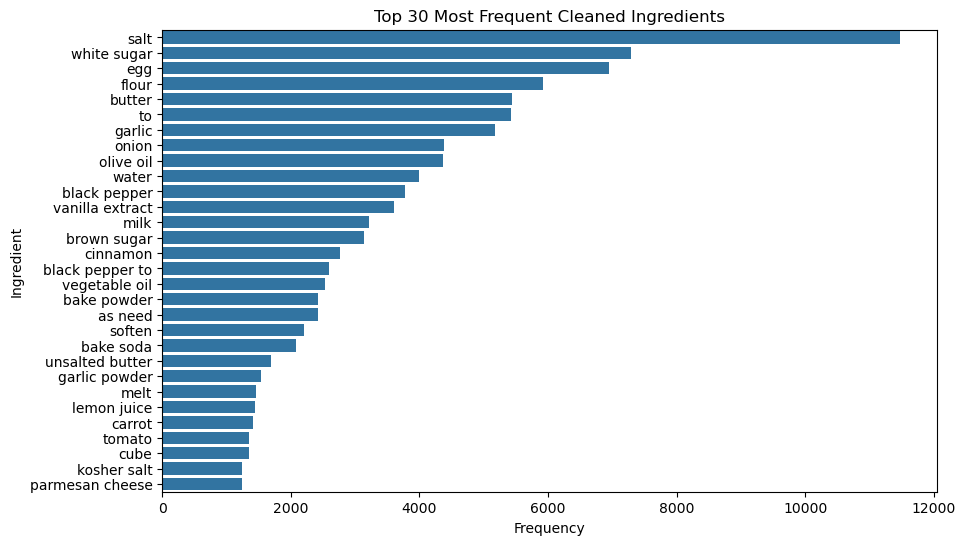

In [44]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df2.head(30),
    x="count", y="ingredient"
)
plt.title(f"Top 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

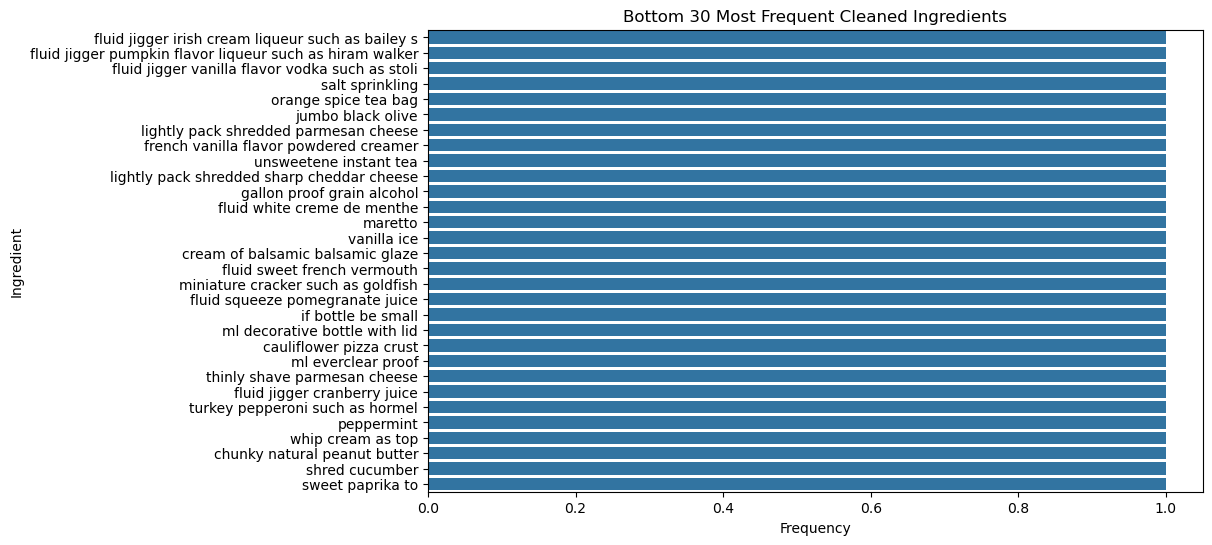

In [45]:
# Visualizing ingredient frequency
plt.figure(figsize=(10,6))
sns.barplot(
    data=freq_df2.tail(30),
    x="count", y="ingredient"
)
plt.title(f"Bottom 30 Most Frequent Cleaned Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()

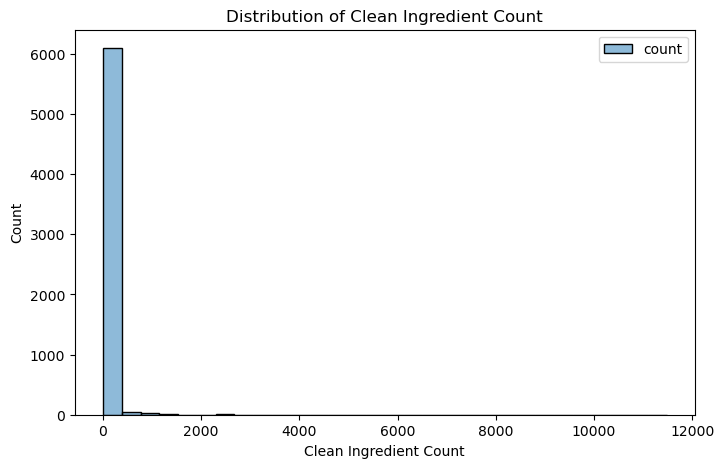

In [46]:
# Ingredient Count Distribution
plt.figure(figsize=(8,5))
sns.histplot(freq_df2[freq_df2["count"] > 1], bins=30)
plt.title("Distribution of Clean Ingredient Count")
plt.xlabel("Clean Ingredient Count")
plt.show()

***Vocabulary Quality Checks***

In [47]:
# Ckeck long ingredient names
freq_df2[freq_df2["ingredient"].str.len() > 20].head(20)

,ingredient,count
216,shred mozzarella cheese,513
261,unsweetene cocoa powder,494
648,semisweet chocolate chip,391
965,sweeten condense milk,282
2286,shred sharp cheddar cheese,170
2597,condense cream of mushroom soup,161
1304,shred monterey jack cheese,158
236,graham cracker crumbs,125
53,nonstick cooking spray,124
172,shred parmesan cheese,116


In [48]:
# Check if any entry still contains digits
freq_df2[freq_df2["ingredient"].str.contains(r"\d")].head()

,ingredient,count


***Problems with Previous Cleaning Functions***
1. Aggressive cleaning takes out potentially valid ingredients.
2. Reliant on manually curated words to remove, which is neither a realistic nor scalable approach.
3. Doesn't deal with spelling errors.

#### New Cleaning Strategy
* Based on the output of the cleaning function, performing the cleaning in multiple steps (function) is not only a good idea...it is the best possible design for ingredient extraction.  
* Trying to force everything into a single pass quickly becomes unmanageable.  
* Splitting the process makes your pipeline modular, extensible, debuggable, and scalable.

In [ ]:
# Re-initializing ingredients dataframe
ingredients_df = deduplicated_df[["ingredients"]]
ingredients_df = ingredients_df.copy()
ingredients_df.shape

In [ ]:
# Extracting a sample for running quick cleanup tests
testdf = ingredients_df.head(100)
testdf = testdf.copy()

## Multi-Stage Cleaning

Stage 1 - text normalization and basic cleanup
Stage 2 - token cleanup (light, safe)
Stage 3 - 

### Stage 1
Goals:  
Remove:
- numbers
- units
- prep words (chopped, diced, sliced…)
- unwanted punctuation

Keep:
- ingredient qualifiers (fresh, smoked, dark, light, sweet, sour, roasted…)
- flavor words (hot, mild, spicy…)
- adjectives that change the meaning

Example:
“1 large fresh basil, chopped”  
→ should become  
“fresh basil”

In [60]:
def clean_stage1(raw):
    raw = raw.lower().strip()
    
    # Replace unicode fractions
    UNICODE_FRAC = {"½": "1/2", "¼": "1/4", "¾": "3/4", "⅓": "1/3", "⅔": "2/3", "⅛": "1/8"}
    for frac, val in UNICODE_FRAC.items():
        raw = raw.replace(frac, val)
        
    # Remove “such as ...” example clauses
    raw = re.sub(r"such as [a-zA-Z\s']+", " ", raw)
    
    # Remove numbers but keep B12/B6 etc.
    raw = re.sub(r'\b\d+(\.\d+)?\b(?![a-zA-Z])', ' ', raw)

    # Remove numeric quantities
    # raw = re.sub(r"(\d+\/\d+|\d+\.\d+|\d+)", " ", raw)

    # Remove measurement units
    raw = re.sub(r"\b(cup|cups|tbsp|tablespoon|tablespoons|tsp|teaspoon|teaspoons|oz|ounce|ounces|gram|grams|kg|kilogram|kilograms|pound|pounds|lb|\
                 pinch|pint|quart|quartered|dash|sprig|inch|inches)\b", " ", raw)

    # Remove preparation-only words (but do not remove meaningful adjectives)
    PREP_WORDS = r"(chopped|diced|minced|sliced|skinned|peeled|halved|shucked|shredded|grated|trimmed|rinsed|patted|divided|optional|crush|crushed|garnish|\
        cooked|prepared|cut|pat|dry|thaw|drained|refrigerate|frozen|thawed|remove)"
    raw = re.sub(rf"\b{PREP_WORDS}\b", " ", raw)

    # Remove other terms
    OTHER_WORDS = r"(plus|more|into|for|extra|additional|taste|package|bag|box|can|jar|bottle|container|about|total|desired|needed|serving|note)"
    raw = re.sub(rf"\b{OTHER_WORDS}\b", " ", raw)

    # Remove punctuation while leaving some possible ingredient connectors
    raw = re.sub(r"[^\w\s/,&-]", " ", raw)

    # Collapse whitespace
    raw = re.sub(r"\s+", " ", raw).strip()
    
    return raw

In [61]:
# Apply to dataset
ingredients_df["clean_ingredients_stage1"] = ingredients_df["ingredients"].apply(
    lambda lst: [clean_stage1(raw) for raw in lst]
)

# Preview
ingredients_df[['ingredients', 'clean_ingredients_stage1']].head(10)

,ingredients,clean_ingredients_stage1
0,"(1 tablespoon worcestershire sauce, 1/2 cup beer, 1/2 teaspoon garlic powder, 1/2 teaspoon onion powder, 1/4 teaspoon cayenne, 2 baking potatoes, 3/4 cup ketchup, olive oil coo...","[worcestershire sauce, / beer, / garlic powder, / onion powder, / cayenne, baking potatoes, / ketchup, olive oil cooking spray, salt and freshly ground black pepper]"
1,"(1 pound pork belly, 1 tablespoon honey,, 1 teaspoon ground ginger, 1/4 cup gochujang, 2 tablespoons soy sauce)","[pork belly, honey,, ground ginger, / gochujang, soy sauce]"
2,"(1 tablespoon olive oil, 1 ¼ pounds chicken tenders, 1/3 cup everything bagel seasoning or to taste)","[olive oil, / chicken tenders, / everything bagel seasoning or to]"
3,"(1 1/2 cups panko breadcrumbs, 2 large eggs, 2 tablespoons milk, 3 ablespoons verything bagel seasoning, 3/4 cup all-purpose flour, 4 chicken cutlets (about 1 pound total), oli...","[/ panko breadcrumbs, large eggs, milk, ablespoons verything bagel seasoning, / all-purpose flour, chicken cutlets, olive oil cooking spray, parchment, salt and freshly ground ..."
4,"(1 tablespoon honey, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon rice vinegar, 1/4 teaspoon granulated garlic)","[honey, soy sauce, sriracha, rice vinegar, / granulated garlic]"
5,"(1 teaspoon lime juice, 2 ears corn, shucked and halved, 2 teaspoons crumbled cotija cheese, 4 sprigs fresh cilantro, or to taste (optional), ¼ cup mayonnaise, ¼ teaspoon chili...","[lime juice, ears corn, and, crumbled cotija cheese, sprigs fresh cilantro, or to, / mayonnaise, / chili powder]"
6,"(1 lime, zested and juiced, 1 tablespoon fresh ginger, 1 tablespoon soy sauce, 1 tablespoon sriracha, 1 teaspoon granulated garlic, 1/3 cup creamy peanut butter, 2 cups cooked ...","[lime, zested and juiced, fresh ginger, soy sauce, sriracha, granulated garlic, / creamy peanut butter, cooked rice, or as, thai sweet chili sauce, skinless, boneless chicken t..."
7,"(1 onion, 1/2 teaspoon cayenne pepper, 1/4 cup all-purpose flour, 1/4 teaspoon salt, or to taste, cooking spray)","[onion, / cayenne pepper, / all-purpose flour, / salt, or to, cooking spray]"
8,"(1 pound baby carrots, 2 tablespoons butter,, 3 tablespoons hot honey, such as mike's hot honey®, nonstick cooking spray)","[baby carrots, butter,, hot honey,, nonstick cooking spray]"
9,"(1 1/2 teaspoons olive oil, 1 large onion, salt and freshly ground black pepper)","[/ olive oil, large onion, salt and freshly ground black pepper]"


### Stage 2
Goals:
1. *Tokenization / splitting*: Split each Stage 1 ingredient string into smaller fragments using commas, slashes, and connectors like `and` / `or`.

2. *Garbage filtering*: Removed obvious non-ingredient tokens (empty strings, punctuation, leftover measurement words, repeated nonsense).

3. *Multi-word ingredient extraction*: Used **spaCy POS-based noun chunking** to preserve meaningful multi-word ingredients (`garlic powder`, `olive oil cooking spray`). Handled phrases like `salt and black pepper` by splitting them into multiple ingredients safely.

4. *Descriptor removal*: Stripped safe descriptive words like (`fresh`, `large`, `boneless`, `sliced`) while keeping food meaning intact.

5. *Filler word removal*: Removed generic stopwords (`and`, `to`, `or`, `for`, etc.) from the final ingredient tokens.

6. *Deduplication & list cleaning*: Flattened and deduplicated ingredient tokens while preserving their original order per recipe.

In [76]:
nlp = spacy.load("en_core_web_md")

def split_tokens(text):
    """
    Split Stage-1 cleaned text into tokens.
    Uses commas, slashes, ' and ', ' or ' etc.
    """
    # replace and/or with comma (but not inside ingredient names)
    text = re.sub(r"\s+(and|or|\&)\s+", ",", text)

    # split on commas or slashes
    raw_tokens = re.split(r"[,/]", text)

    # clean whitespace
    return [t.strip() for t in raw_tokens if t.strip()]


def looks_like_garbage(token):
    """
    Shape-based garbage detection.
    No vocabulary lists — entirely rule-based.
    """
    t = token.lower().strip()

    # too short (except valid short ingredients)
    if len(t) <= 2 and t not in {"oil", "yam", "tea"}:
        return True

    # remove tokens ending in filler words
    if re.search(r"(needed|serving|taste|note)$", t):
        return True

    # remove repeated nonsense like "wet wet sauce"
    if re.search(r"\b(\w+)\s+\1\b", t):
        return True

    # no alphabetic characters
    if not re.search(r"[a-zA-Z]", t):
        return True
    
    return False


def extract_ingredient_phrase(t):
    """
    Extracts the main ingredient phrase using POS-based noun chunking,
    preserving multiword ingredients naturally.
    """
    t = t.strip().lower()

    # Salt-and-pepper pattern
    if " and " in t:
        parts = [extract_ingredient_phrase(x) for x in t.split(" and ")]
        flat = []
        for p in parts:
            if isinstance(p, list):
                flat.extend(p)
            else:
                flat.append(p)
        return flat

    doc = nlp(t)

    # POS-based chunks (noun phrases)
    noun_chunks = [chunk.text for chunk in doc.noun_chunks]

    if noun_chunks:
        phrase = noun_chunks[-1]  # get the main noun phrase
    else:
        phrase = t

    # Remove undesirable descriptors but keep food words
    DESCRIPTORS = {
        "large", "small", "fresh", "freshly", "boneless", "skinless", "zested", "juiced", "minced"
        "ground", "crushed", "sliced", "diced", "creamy", "halved"
    }

    words = []
    for w in phrase.split():
        if w not in DESCRIPTORS:
            words.append(w)

    cleaned = " ".join(words).strip()

    return cleaned


def remove_filler_words(phrase):
    """
    Removes standalone filler words from final ingredient tokens,
    but does NOT destroy valid multiword ingredient names.
    """
    FILLER_STOPWORDS = {
        "and", "to", "or", "for", "with", "in", "of", "the",
        "a", "an", "as", "on", "into", "at"
        }
    words = phrase.split()
    words = [w for w in words if w not in FILLER_STOPWORDS]
    return " ".join(words).strip()


def clean_stage2(stage1_output):
    tokens = split_tokens(stage1_output)

    cleaned = []

    for t in tokens:
        t = t.strip().lower()
        
        # remove leading/trailing punctuation
        t = re.sub(r"^[^\w]+|[^\w]+$", "", t)

        # Skip garbage tokens
        if looks_like_garbage(t):
            continue

        # Extract ingredient phrase
        extracted = extract_ingredient_phrase(t)

        # handle salt-and-pepper cases (list return)
        if isinstance(extracted, list):
            for x in extracted:
                x = remove_filler_words(x)
                if x and not looks_like_garbage(x):
                    cleaned.append(x)
        else:
            x = remove_filler_words(extracted)
            if x and not looks_like_garbage(x):
                cleaned.append(x)

    # Remove duplicates while maintaining order
    final = list(dict.fromkeys(cleaned))
    return final

In [ ]:
# Apply to dataset
testdf["clean_ingredients_stage2"] = testdf["clean_ingredients_stage1"].apply(
    lambda lst: [clean_stage2(raw) for raw in lst]
)

# Preview
testdf[['clean_ingredients_stage1', 'clean_ingredients_stage2']].head(10)

,clean2
0,"[[worcestershire sauce], [beer], [garlic powder], [onion powder], [cayenne], [potatoes], [ketchup], [olive oil cooking spray], [salt, ground black pepper]]"
1,"[[pork belly], [honey], [ground ginger], [gochujang], [soy sauce]]"
2,"[[olive oil], [chicken tenders], [everything]]"
3,"[[breadcrumbs], [eggs], [milk], [ablespoons], [all-purpose flour], [chicken cutlets], [olive oil cooking spray], [parchment], [salt, ground black pepper]]"
4,"[[honey], [soy sauce], [sriracha], [rice vinegar], [granulated garlic]]"
5,"[[lime juice], [ears], [crumbled cotija cheese], [cilantro], [mayonnaise], [chili powder]]"
6,"[[lime], [ginger], [soy sauce], [sriracha], [granulated garlic], [peanut butter], [cooked rice], [thai sweet chili sauce], [chicken thighs], [cilantro], [cooking spray], [roast..."
7,"[[onion], [cayenne pepper], [all-purpose flour], [salt], [cooking spray]]"
8,"[[baby carrots], [butter], [hot honey], [nonstick cooking spray]]"
9,"[[olive oil], [onion], [salt, ground black pepper]]"


### Stage 3

# Others

***Ingredient-Category Relationship***

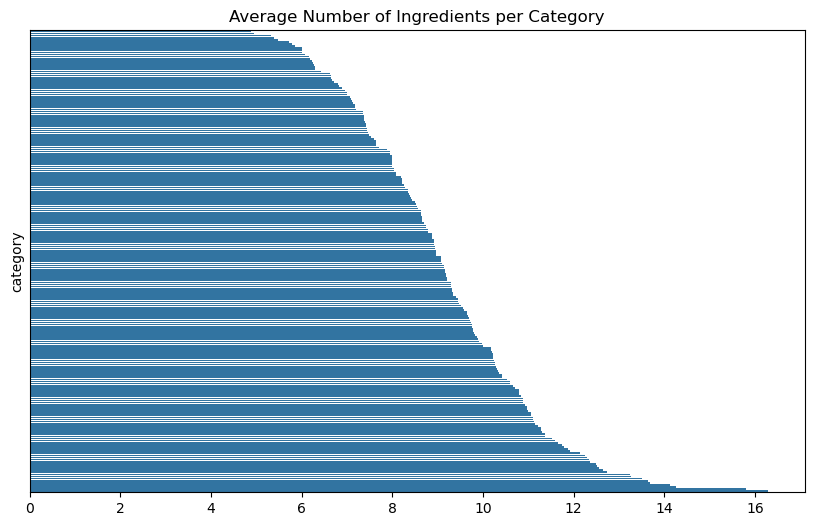

In [ ]:
# Average number of ingredients per category:
cat_ing_avg = deduplicated_df.groupby("category")["num_ingredients"].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=cat_ing_avg.values, y=cat_ing_avg.index)
plt.title("Average Number of Ingredients per Category")
plt.yticks(ticks=[])
plt.show()

In [52]:
# Identify category-unique ingredients
exclusive = {}

for cat, group in deduplicated_df.groupby("category"):
    exclusive[cat] = set(
        ing for lst in group["clean_ingredients_final"] for ing in lst
    )

all_set = reduce(set.union, exclusive.values())

unique_by_cat = {
    cat: ings - reduce(set.union, [exclusive[c] for c in exclusive if c != cat])
    for cat, ings in exclusive.items()
}

# Example: ingredients unique to "Air Fryer Recipes"
unique_by_cat.get("Air Fryer Recipes", set())

{'any color bell pepper',
 'apricot fruit spread',
 'assorted root vegetable carrot',
 'avocado oil nonstick cooking spray',
 'bag tortilla chip',
 'bagel season such as s everything but the bagel sesame seasoning blend',
 'black truffle sea salt',
 'bread crispy chicken strip such as',
 'bunchgreen onion',
 'cajun seasoning such as old bay',
 'cheese cracker such as',
 'cheese see note',
 'chicken cutlet total',
 'chicken taquito',
 'cream cheese neufchâtel',
 'day old bagel',
 'dill serve',
 'drizzle of buffalo wing sauce',
 'dust cake pan',
 'each short piece',
 'flakey salt to',
 'frozen cauliflower tot such as green giant cauliflower veggie tot',
 'frozen phyllo dough',
 'frozen waffle',
 'fryer chicken',
 'giant white corn such as',
 'in half widthwise',
 'italian hot sausage link',
 'lbs pork tenderloin',
 'lbs sirloin',
 'mango chutney such as s',
 'maple syrup to',
 'mojo criollo marinade such as',
 'ntreal steak season',
 'nugget size',
 'oil sealing',
 'other seasoning of ch

***Ingredient Co-Occurrence Matrix*** (using cleaned ingredients)

In [50]:
N = 50
top_clean = freq_df2.head(N)["ingredient"].tolist()

co_matrix = pd.DataFrame(0, index=top_clean, columns=top_clean)

for ing_list in deduplicated_df["clean_ingredients_final"]:
    ings = [i for i in ing_list if i in top_clean]
    for a, b in combinations(sorted(set(ings)), 2):
        co_matrix.at[a, b] += 1
        co_matrix.at[b, a] += 1

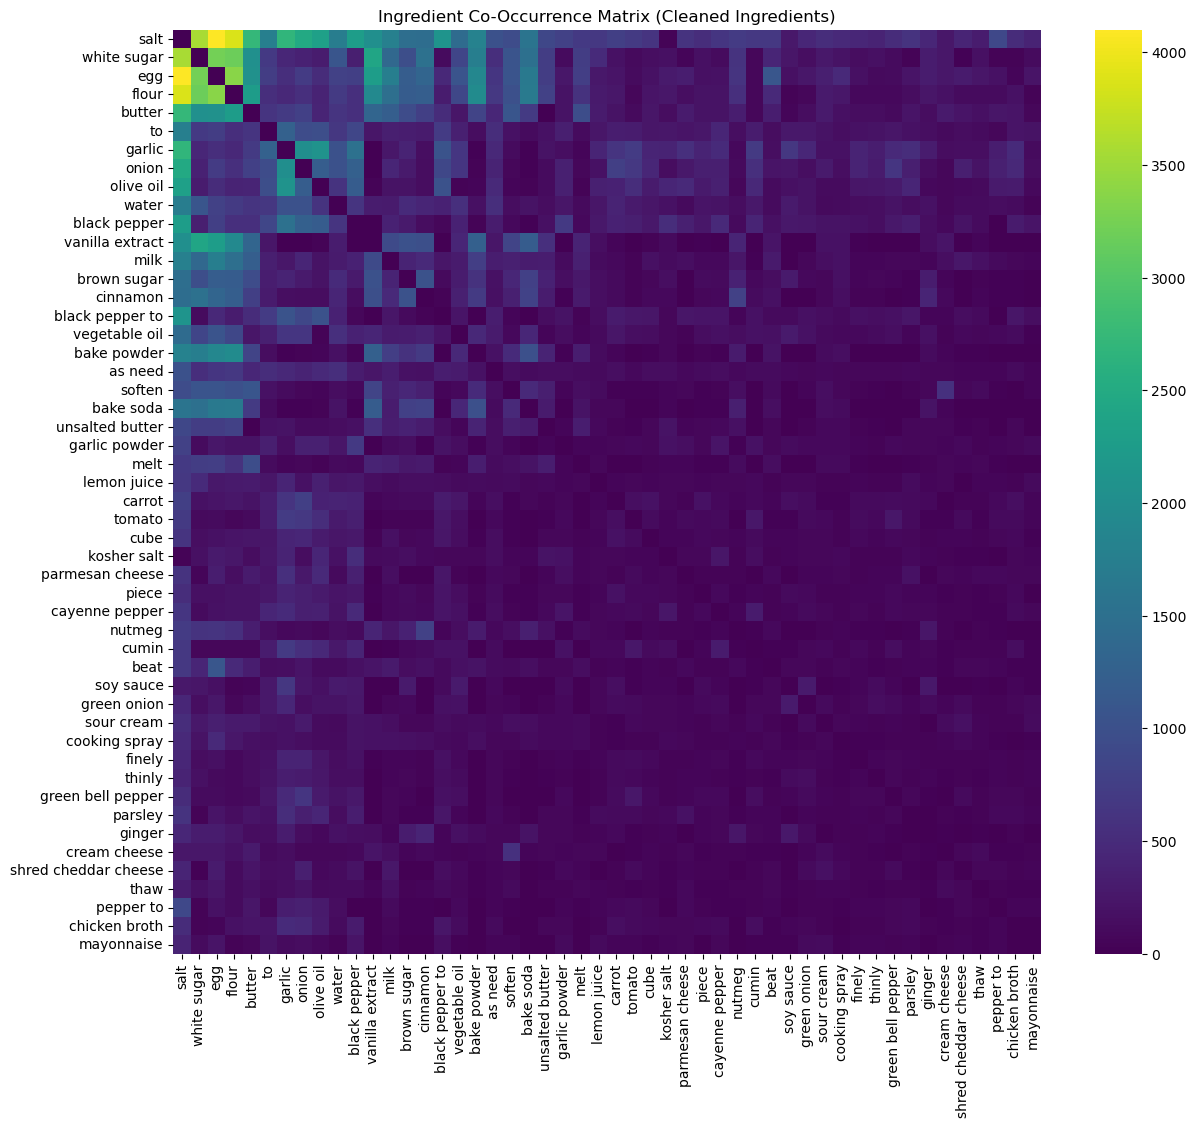

In [51]:
plt.figure(figsize=(14,12))
sns.heatmap(co_matrix, cmap="viridis")
plt.title("Ingredient Co-Occurrence Matrix (Cleaned Ingredients)")
plt.show()